In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, I will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trimming the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

<AxesSubplot:xlabel='Date'>

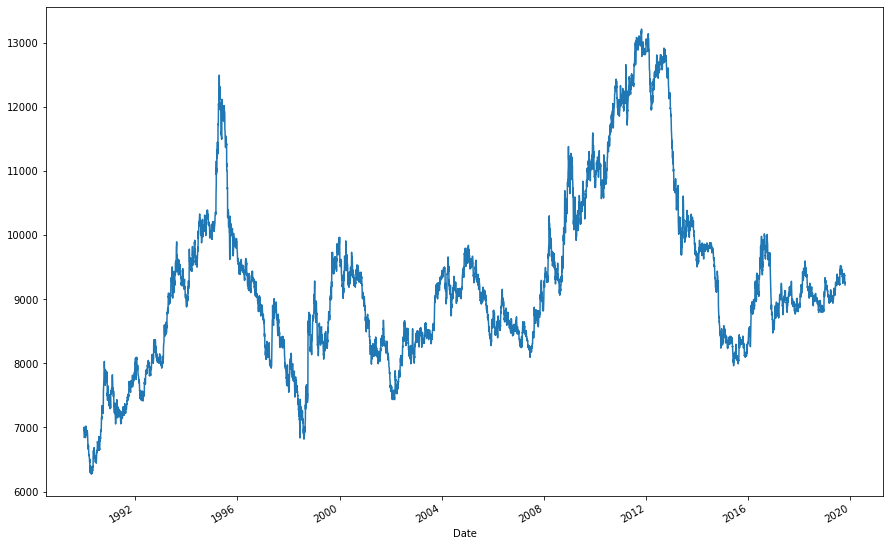

In [4]:
# Plotting just the "Settle" column from the dataframe:
yen_futures.Settle.plot(figsize=(15,10))

##It can be said that based on the graph, the yen price is showing a long-term positive growth 

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, I decomposed the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Applying the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:

yen_futures_noise, yen_futures_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])

In [6]:
# Creating a dataframe of just the settle price, and adding columns for "noise" and "trend" series from above:

yen_settle = yen_futures.loc["1990-01-01":,"Settle"]
yen_df = pd.concat([yen_settle, yen_futures_noise, yen_futures_trend], axis= 'columns', join='inner')
yen_df.columns


# Rewriting the column names
columns = ["Settle", "Noise", "Trend"]
yen_df.columns = columns
yen_df.head()



,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:xlabel='Date'>

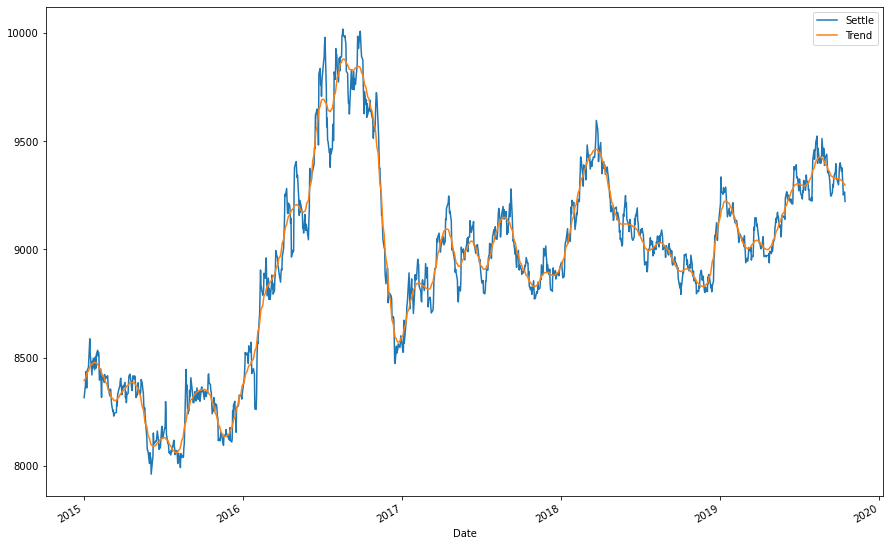

In [7]:
# Plotting the Settle Price vs. the Trend for 2015 to the present
yen_df_2015 = yen_df.loc["2015":]
yen_df_2015.plot(y=["Settle", "Trend"],figsize=(15,10))

<AxesSubplot:xlabel='Date'>

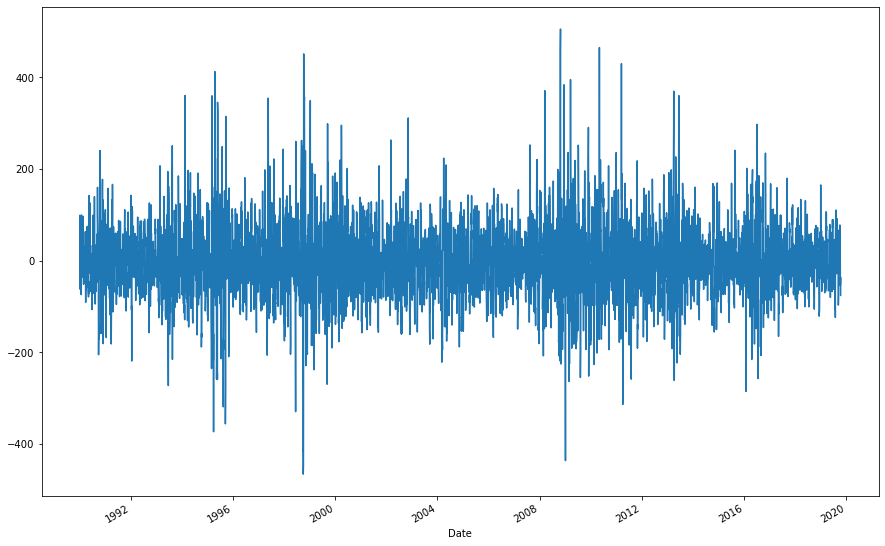

In [8]:
# Plotting the Settle Noise

yen_df.Noise.plot(figsize=(15,10))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, I am estimating an ARMA model

In [9]:
# Creating a series using "Settle" price percentage returns, dropping any nan"s, and checking the results:
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.head()

,Settle
Date,
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496
1990-01-09,-0.632275


In [10]:
import statsmodels.api as sm

# Estimating an ARMA model using statsmodels (using order=(2, 1))
from statsmodels.tsa.arima_model import ARMA
model = ARMA(returns.values, order=(2, 1))

# Fitting the model and assigning it to a variable called results_ARMA
results_ARMA = model.fit()

/Users/abraraman/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [11]:
# Outputting model summary results:
results_ARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sat, 31 Jul 2021   AIC                          15798.142
Time:                        22:31:40   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3060      1.278     -0.239      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2944      1.278      0.230      0.818      -2.210       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3375           +0.0000j            3.3375            0.5000
AR.2         -157.2840           +0.0000j          157.2840            0.5000
MA.1           -3.3966           +0.0000j            3.3966            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

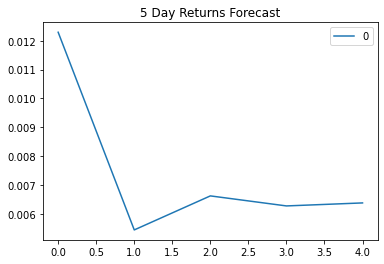

In [12]:
# Plotting the 5 Day Returns Forecast
pd.DataFrame(results_ARMA.forecast(steps=5)[0]).plot(title= "5 Day Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimating an ARIMA Model:

model = ARIMA(yen_futures.Settle.values, order=(5, 1, 1))  

# Fitting the model
results_ARIMA = model.fit()  

/Users/abraraman/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/abraraman/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.t

In [14]:
# Outputting model summary results:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Sat, 31 Jul 2021   AIC                          83905.238
Time:                        22:31:41   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3162      0.700      0.452      0.651      -1.056       1.688
ar.L1.D.y      0.2826      0.699      0.404      0.686      -1.087       1.652
ar.L2.D.y      0.0007      0.016      0.043      0.965      -0.030       0.032
ar.L3.D.y     -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.y     -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.y     -0.0011      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.y     -0.2976      0.699     -0.426      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8922           -1.3782j            2.3410           -0.1002
AR.2            1.8922           +1.3782j            2.3410            0.1002
AR.3           -2.2725           -3.0188j            3.7785           -0.3527
AR.4           -2.2725           +3.0188j            3.7785            0.3527
AR.5          -11.1557           -0.0000j           11.1557           -0.5000
MA.1            3.3597           +0.0000j            3.3597            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Days Futures Price Forecast'}>

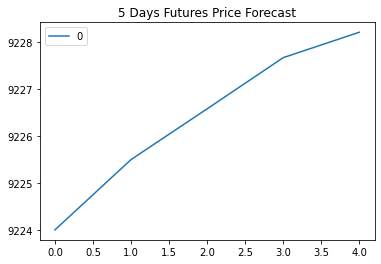

In [15]:
# Plotting the 5 Day Price Forecast
pd.DataFrame(results_ARIMA.forecast(steps=5)[0]).plot(title="5 Days Futures Price Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
from arch import arch_model

In [17]:
# Estimating a GARCH model:
model = arch_model(returns.Settle, mean="Zero", vol="GARCH", p=2, q=1)
results_GARCH = model.fit(disp="off")

# Fitting the model
results_GARCH = model.fit(disp="off")


In [18]:
# Summarizing the model results
results_GARCH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Sat, Jul 31 2021   Df Residuals:                     7514
Time:                        22:31:42   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [19]:
# Finding the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [20]:
# Creating a 5 day forecast of volatility
forecast_horizon = 5
# Starting the forecast using the last_day calculated above
forecasts = results_GARCH.forecast(start=last_day, horizon=forecast_horizon)

/Users/abraraman/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [21]:
# Annualizing the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434032,7.475729,7.516851,7.55741,7.597418


In [22]:
# Transposing the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434032
h.2,7.475729
h.3,7.516851
h.4,7.557410
h.5,7.597418


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

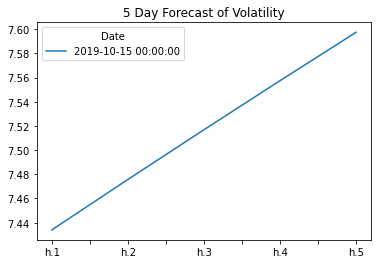

In [23]:
# Plotting the final forecast
final.plot(title="5 Day Forecast of Volatility")

---

# Conclusions

Based on the time series analsyis I have conducted, I would advise investors to refrain from buying the Yen (relative to the U.S dollar), as the yen does not show promising results for growth. According to the ARMA model, it can be deduced that the yen may underperform in the long-run. Although the forecast from the ARIMA model may argue otherwise (as it shows increase in future price),the volatility forecast derived from the GARCH model suggests that the risk of the yen is expected to increase. In addition, the p value for the GARCH model is below 0.5, which further reinforces that the GARCH volatitliiy predictions may hold true. Hence, it is best to hold off from investing in the yen (for now).